# Duas abordagens para identificação de valência em um corpus de manchetes de jornais em português brasileiro

Caluã de Lacerda Pataca / RA 015605

---

## Introdução

Neste exercício, busquei explorar dois diferentes métodos para identificação de valência em manchetes jornalísticas: 
1. Análise baseada em léxico;
2. Análise baseada em machine learning.

O motivo de serem duas as abordagens deriva de, em meus primeiros experimentos, sentir que a qualidade dos resultados deixava a desejar. Ao desenvolver a segunda tentativa (como comentarei abaixo) entendi melhor algumas nuances do problema que, de certa forma, dificultam uma solução “perfeita”, então se não aprofundei em nenhuma das abordagens por um lado, pude entender melhor no que cada uma tem potencial de funcionar melhor.

Seja como for, as duas abordagens estão comentadas abaixo, com algumas notas gerais ao final. 

O código criado é entremeado pelos comentários, mas o publiquei na integra no [Github](https://github.com/caluap/IA369Y-T2), junto com a base comentada que uso na abordagem 2. Com exceção de algumas mensagens impressas, o código e seus comentários internos fiz em inglês — me pareceu apropriado, dado que ele se insere num contexto no qual os exemplos estão todos nessa língua.

---

## Analisador léxico

A princípio, me pareceu um bom ponto de partida uma abordagem mais simples, baseada em medição de polaridade no nível palavra-a-palavra: Há diversas bibliotecas com léxicos classificados de fácil acesso e, caso me perdesse, não seria difícil encontrar referências que explorassem o tópico.

### Escolha de um léxico

As notícias a se analisar não tem tema definido, e apesar de uma certa predominância de manchetes políticas eu deveria supor uma certa generalidade de assuntos, ou seja, não faria sentido escolher um [léxico especializado](https://nlp.stanford.edu/projects/socialsent/) em algum domínio.

Além disso, há também a questão da língua: Há [um](http://csea.phhp.ufl.edu/media/anewmessage.html) [sem](http://sentiwordnet.isti.cnr.it/) [número](https://github.com/cjhutto/vaderSentiment) [de](http://www.wjh.harvard.edu/~inquirer/homecat.htm) [opções](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon) [em](http://liwc.wpengine.com/) [inglês](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/), mas as opções em português são mais raras, nem sempre disponíveis para Python.

Ao final de alguma pesquisa, optei pela [Sentic.Net](http://sentic.net/), pois além de estar em português e de disponibilizar para dada palavra uma medida de polaridade (-1 a 1), há alguns dados adicionais bastante interessantes: quatro dimensões de sentimento, ou _sentics_ (_pleasantness_, _attention_, _sensitivity_ e _aptitude_), e conceitos relacionados (relacionados à palavra _dog_, por exemplo, estariam palavras como _pet_, _best friend_, _cur_ etc). 

No momento em que fiz a escolha, essas dimensões extras me pareceram indicar possíveis maneiras de complementar a aplicação — como inclusive [apareceu](https://github.com/antonmc/moods) num exemplo de aplicação da API da IBM de análise de sentimento. Apesar de que isso não foi possível no contexto deste exercício específico, futuras versões poderia se aproveitar dessas possibilidades.

Houve também alguns limites na SenticNet, mas antes de comentá-los cabe aqui compartilhar minhas experiências propriamente:


In [1]:
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from senticnet.senticnet import Senticnet

In [2]:
headlines = {}
polarities = {}
stop_words_pt = stopwords.words('portuguese')

In [3]:
def clean_quotes(s):
  # ending quotes
  s = re.sub("((''|\"|`+)(\.|,|\?|!|;| |:))","”",s)
  # all other quotations (which I imagine are at the start of quotes)
  s = re.sub("(''|\"|`+)","”",s)
  return s

In [4]:
# removes html special characters
# (probably should be smarter to decode them, but...)
def clean_html_chars(s):
  return re.sub('&.+;','',s)

---

Aqui, preciso apenas do tokenizador e stopwords do NLTK. Expressões regulares uso apenas para limpar um pouco as manchetes brutas que, importadas, traziam consigo alguns caracteres estranhos e/ou em padrões divergentes.

Abaixo, a função de importação propriamente.

In [5]:
def create_headline_list(filename):
  f = open(filename,'r')
  text = f.readlines()

  for lines in text:
    values = lines.split(',',4)
    date = (values[2],values[1][1:-1],values[0])
    source = values[3][1:-1]
    headline = values[4][1:-2]
    
    # cleans (somewhat) text of some of its gunk
    headline = clean_quotes(clean_html_chars(headline))

    # source / headline pair
    if date not in headlines:
      headlines[date] = []
      polarities[date] = []
    headlines[date].append((source,headline))
        
  f.close()

Abaixo, o crux desta abordagem: soma-se a polaridade (`w_pol`) de cada palavra (cada `word` em `tokens`), desde que não presente em `stop_words_pt`. Esta polaridade “individual” é então usada para se calcular a polaridade da frase como um todo. São gerados dois valores:
+ `pol`, que é uma soma simples de todas polaridades encontradas;
+ `weighed_pol`, que atribui um peso para cada `w_pol` considerando onúmero de palavras na frase que poderiam ter também polaridades — desconsiderando então as stop words.

Ao final, imprime-se o resultado. Um exemplo:
> ```Temer cobra apoio da base para votar já a Previdência. >>> 0.909 ```

> ```····· 0.062 0.788 __ 0.05 ____ ····· __ _ ············ ```


A convenção de exibição que criei aqui é a seguinte: abaixo de cada palavra, pode haver pontos medianos (`·`), quando não houve retorno de polaridade do SenticNet, traços inferiores (`_`), quando se trata de uma stop word, e a polaridade em si, quando esta há. Ao lado da frase original há também, precedido de `>>>`, a polaridade somada da frase inteira (`pol`).

Há já nesse exemplo uma amostra do problema de que falarei mais a frente: muitas palavras não retornam nada, então a polaridade calculada acaba ignorando muita informação presente na frase — e a `weighed_pol`, por esse mesmo motivo, é aparentemente menos útil ainda, dado que quase sempre está muito próxima de 0.

In [6]:
def calculate_polarity(phrase, print_pol = True):
  tokens = word_tokenize(phrase)
  n_words = len(tokens)

  # pol will sum polarities of all words in the headline divided by number of words
  pol = 0
  weighed_pol = 0

  # this is used for a quick (and dirty) way to print what’s happening under the hood
  polarities_list = ""

  # ... and each word.
  for word in tokens:

    # polarity for each word. if the polarity_value function fails, assumes a neutral (?) zero value
    w_pol = 0
      
    if re.search('(\.|\,|\?|\%|\:)',word) and polarities_list != "":
      polarities_list = polarities_list[:-1]

    if (word not in stop_words_pt):
      try:
        w_pol = sn.polarity_value(word)

        # it won't always work (R$ trips this, for ex), but what this does is show the same number of
        # characters for the polarity as the length of the word, so I can align one under the other
        s_w_pol = str(w_pol) + '                   '
        polarities_list += s_w_pol[:len(word)] + ' '

      except:
        # indicates there was no available polarity
        s_w_pol = '···························'
        polarities_list += s_w_pol[:len(word)] + ' '
    else:
      # words not taken into account will show as underscores
      n_words -= 1
      s_w_pol = '______________'
      
      polarities_list += s_w_pol[:len(word)] + ' '

    pol += w_pol
    
    # weighed by all plausibly polarizing words (all - stop words)
    weighed_pol += w_pol/n_words

  if print_pol:
    print('%s >>> %.5s \n%s\n' % (phrase,pol,polarities_list))
  return (pol,weighed_pol)
  

In [7]:
create_headline_list('manchetes/original.csv')
sn = Senticnet('pt')

In [8]:
# iterates through all dates, ...
for date in headlines:
  # ... each line ...
  for source_and_headline in headlines[date]:

    source = source_and_headline[0]
    headline = source_and_headline[1]
    polarity = calculate_polarity(headline)
    
    polarities[date].append((source, polarity))

BNDES encolhe e volta ao nível de 20 anos atrás >>> 0.563 
····· ······· _ ····· __ 0.563 __ ·· ···· ····· 

BC cria novo instrumento de política monetária. >>> 0.27 
·· ···· 0.10 0.052       __ 0.11     ·········· 

Câmbio gera bate-boca entre UA e UE. >>> 0 
······ ···· ········· _____ ·· _ ··· 

Indenização a transmissoras de energia já chega à tarifa. >>> 0.007 
··········· _ ············· __ -0.103  __ ····· _ 0.11  · 

Políticos esperam que relator separe ”joio do trigo” >>> 0.002 
········· ······· ___ ······· -0.03  · ···· __ 0.032 · 

Philips quer administrar hospitais públicos no Brasil. >>> 0 
······· ···· ··········· ········· ········ __ ······· 

Com vendas em queda, CC muda lojas e troca diretoria. >>> 0.213 
··· ······ __ ······ ·· ···· 0.09  _ 0.123 ·········· 

Fachin poderá ir para turma que julga Lava-Jato. >>> 0.822 
······ ······ 0. ____ ····· ___ ····· ·········· 

Eike tem multas que superam fundo para prisões. >>> -0.05 
···· ___ ······ ___ ······· -0.05 ____ ·


Febre amarela: um milhão já foi vacinado. >>> 0 
····· ········ __ ······ __ ___ ········· 

Alemanha quer multar por notícias falsas. >>> 0.04 
········ ···· ······ ___ 0.04     ······· 

Holanda vai às urnas com 60% de indecisos. >>> 0 
······· ··· __ ····· ___ ··· __ ·········· 

Lista de Janot inclui 5 ministros de Temer, além de Lula e Aécio. >>> 0 
····· __ ····· ······ · ········· __ ······ ···· __ ···· _ ······ 

Ex-presidente depõe e diz que é vítima de ”quase um massacre” >>> -1.03 
············· ····· _ ··· ___ · -0.81  __ · 0.456 __ -0.677   · 

Citados preveem fase crítica por até quatro meses. >>> -0.15 
······· ······· ···· -0.155  ___ ___ ······ ······ 

Bernardo Mello Franco: Pedido cai como bomba nuclear na capital federal. >>> -0.41 
········ ····· ······· ······ ··· ____ -0.49 -0.027  __ ······· 0.106  · 

Casos de suspeita de dengue e zika caem, em média, 90% no ano. >>> 0.036 
····· __ ········ __ ······ _ ···· ····· __ 0.071· ··· __ -0.· 

Protesto contra reform

Acima, todas as manchetes calculadas.

-----------

### Limites e melhorias

A primeira questão que me deparei diz respeito à qualidade dos dados disponíveis na SenticNet, em especial no que diz respeito à lingua portuguesa. Me baseei em [referências](http://www.springer.com/la/book/9783319236537) que consideravam a ferramenta de maneira positiva, mas com exemplos sempre na língua inglesa. Após implementado o algoritmo acima, no entanto, e com mais alguns experimentos, passei a desconfiar de que talvez a base portuguesa da SenticNet não esteja tão madura.

Como exemplo disso, veja os resultados que a SenticNet dá para a palavra “mulher”, em português, e “woman”, em inglês.

In [9]:
sn_port = Senticnet('pt')
sn_port.concept('mulher')

{'moodtags': ['#medo', '#nojo'],
 'polarity_intense': 'cadeira_de_rodas',
 'polarity_value': -0.068,
 'semantics': ['roupa_suja', 'fotografia_antiga', 'gostosa', 'mãezinha'],
 'sentics': {'aptitude': -0.078,
  'attention': 0,
  'pleasantness': -0.045,
  'sensitivity': -0.08}}

In [10]:
sn_eng = Senticnet()
sn_eng.concept('woman')

{'moodtags': ['#joy', '#interest'],
 'polarity_intense': '0.444',
 'polarity_value': 'positive',
 'semantics': ['human_being', 'bloke', 'adult', 'male', 'sexy_woman'],
 'sentics': {'aptitude': '0.295',
  'attention': '0.645',
  'pleasantness': '0.632',
  'sensitivity': '-0.24'}}

Nota-se que há algumas diferenças interessantes. Em primeiro, e foi com isso que surgiu minha suspeita de algo errado, o campo `polarity_intense` em português retorna um valor que faz pouco sentido, ainda mais quando comparado com seu equivalente em inglês. Mas, não só isso, os conceitos semelhantes sugeridos em `semantics` em ambos os casos denunciam que, talvez, a base portuguesa tenha sido criada a partir de poucos dados.

Seja como for, esse ponto serve mais como um comentário geral, pois mesmo com algumas polaridades um pouco duvidosas espalhadas pelos resultados calculados, a questão principal que limita eficacia aqui talvez seja o próprio simplismo da abordagem. Algumas sofisticações não exploradas que talvez aumentassem a sutileza do algoritmo:

+ Lemmatizar palavras não encontradas — infelizmente não encontrei no NLTK ou em bibliotecas (pelo menos não [para Python](https://github.com/rikarudo/LemPORT)) maneiras de se buscar lemmas (uma versão mais geral de dada palavra). Tampouco, sinônimos. Estes poderiam ser usados como equivalências sempre que a SenticNet não encontrasse polaridade de uma dada palavra.
+ Ao invés de um teste palavra-a-palavra, poder-se-ia testar também “[chunks](https://pythonprogramming.net/chunking-nltk-tutorial/)”, que possivelmente retornariam polaridades melhor ponderadas (e nos exemplos para _mulher_ e _woman_ acima é possível ver alguns exemplos de termos compostos (chunks) que constam na SenticNet — `roupa_suja`, `fotografia_antiga`, `human_being`, `sexy_woman`).
+ O algoritmo poderia considerar algumas palavras como incrementos ou decrementos de polaridade. Por exemplo, qualquer palavra que seja antecedida por “muito” deveria ter sua pontuação multiplicada por algum fator. “Pouco” teria o efeito oposto.

Ademais, faria sentido medir também — e isso mais num sentido de entendimento de possíveis vieses dos jornais do que propriamente uma melhoria no algoritmo em si, ou melhor dizendo, algo pensado em termos **da aplicação** mais do que da técnica — se determinadas personalidades são melhor ou pior retratadas por diferentes jornais e/ou em diferentes períodos. 

Por exemplo:



In [11]:
def subject_neutrality(who, source=None):
  pol_sub = 0
  n_sub = 0
  for date in headlines:
    for s_h in headlines[date]:
      headline = s_h[1]
      if s_h[0] == source or source == None:
        if re.search(who,headline):
          pol_sub += calculate_polarity(headline, False)[0]
          n_sub += 1
          
  s_source = ""
  if source != None:
   s_source = "na fonte “%s” " % source
  
  if n_sub > 0:
    av_sub = pol_sub/n_sub
    if av_sub < -0.25: 
      print("A polaridade média de notícias que citam “%s” %sé negativa. (%.5s)" % (who, s_source, av_sub))
    elif av_sub > 0.25: 
      print("A polaridade média de notícias que citam “%s” %sé positiva. (%.5s)" % (who, s_source, av_sub))
    else:
      print("A polaridade média de notícias que citam “%s” %sé neutra. (%.5s)" % (who, s_source, av_sub))
  else:
    print("Nenhuma notícia que cita “%s” %s." % (who, s_source))
    
    
    
subject_neutrality("PT")
subject_neutrality("PSDB")
subject_neutrality("Temer")
subject_neutrality("Lula")
subject_neutrality("Dilma")
subject_neutrality("Doria")
subject_neutrality("Haddad")

A polaridade média de notícias que citam “PT” é negativa. (-0.37)
A polaridade média de notícias que citam “PSDB” é neutra. (-0.17)
A polaridade média de notícias que citam “Temer” é neutra. (0.133)
A polaridade média de notícias que citam “Lula” é positiva. (0.274)
A polaridade média de notícias que citam “Dilma” é positiva. (0.258)
A polaridade média de notícias que citam “Doria” é neutra. (0.015)
A polaridade média de notícias que citam “Haddad” é negativa. (-0.63)


---

Ou seja, fosse o algoritmo mais confiável esta seria uma ferramenta interessante para se medir de maneira sistemática para que lado pende uma dada cobertura jornalística.

Outro uso interessante é comparar como que determinados veículos tratam diferentes temas:

In [12]:
subject_neutrality("Lula", "Valor")
subject_neutrality("Lula", "Estado")
subject_neutrality("Lula", "Folha")
subject_neutrality("Lula", "Globo")

print("\n")

subject_neutrality("Temer", "Valor")
subject_neutrality("Temer", "Estado")
subject_neutrality("Temer", "Folha")
subject_neutrality("Temer", "Globo")

Nenhuma notícia que cita “Lula” na fonte “Valor” .
A polaridade média de notícias que citam “Lula” na fonte “Estado” é positiva. (0.394)
A polaridade média de notícias que citam “Lula” na fonte “Folha” é positiva. (0.364)
A polaridade média de notícias que citam “Lula” na fonte “Globo” é neutra. (-0.08)


A polaridade média de notícias que citam “Temer” na fonte “Valor” é neutra. (0.067)
A polaridade média de notícias que citam “Temer” na fonte “Estado” é positiva. (0.294)
A polaridade média de notícias que citam “Temer” na fonte “Folha” é neutra. (-0.18)
A polaridade média de notícias que citam “Temer” na fonte “Globo” é positiva. (0.367)


---

Nesse sentido, seria possível inclusive pesquisar afiliação partidária de cada pessoa citada, de modo a expandir uma tendência mais geral (apesar de fugir ao escopo aqui, parte desses dados poderiam ser recuperados via [site do TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/candidatos_anos/2016.html), que os disponibiliza em formatos pesquisáveis).

(Estou aqui ignorando a quantidade de notícias sobre cada tema, ou seja, não me preocupando se de fato há volume suficiente em cada tema para se falar de tendências gerais, mas esse não seria um passo impossível caso se quisesse de fato avançar a aplicação.)

----------

Seja como for, apresento abaixo algumas visualizações que resumem as tendências gerais dos resultados.

In [13]:
# import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
sns.set(style="whitegrid",palette="muted", color_codes=True)

In [15]:
# extracts simple polarities
p1 = [polarities[date][0][1][0] for date in polarities.keys()]

In [16]:
# extracts weighed polarities
p2 = [polarities[d][0][1][1] for d in polarities.keys()]

---

#### Abaixo, a distribuição das polaridades, primeiro sem fazer o peso de cada palavra dentro da frase, segundo fazendo.

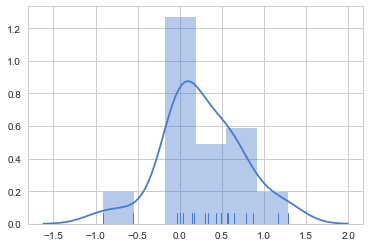

In [17]:
simple_sentic = sns.distplot(p1, rug="True")
plt.show()

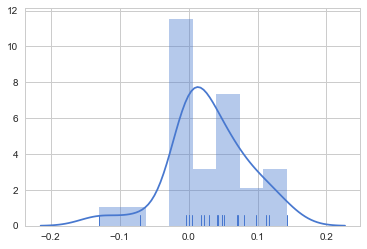

In [18]:
weighed_sentic = sns.distplot(p2, rug="True")
plt.show()

In [19]:
valor = []
folha = []
estado = []
globo = []

for d in polarities.keys():
  for h in polarities[d]:
    if h[0] == 'Valor':
      valor.append(h[1][0])
    elif h[0] == 'Folha':
      folha.append(h[1][0])
    elif h[0] == 'Estado':
      estado.append(h[1][0])
    elif h[0] == 'Globo':
      globo.append(h[1][0])
      
sns.distplot(valor, hist=False, label='Valor')
sns.distplot(folha, hist=False, label='Folha')
sns.distplot(estado, hist=False, label='Estado')
sns.distplot(globo, hist=False, label='Globo')

---

#### As distribuições de polaridades entre os 4 veículos:

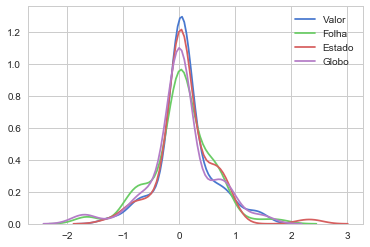

In [20]:
plt.show()

---

Talvez seja mais fácil fazer a comparação usando um gráfico do tipo `violinplot`:

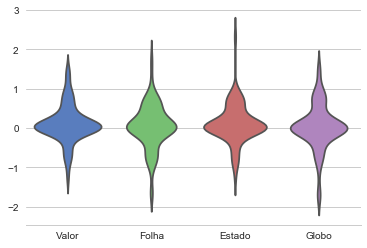

In [21]:
g = sns.violinplot(data=[valor,folha,estado,globo],inner=None)
sns.despine(left=True)
g.set_xticklabels(["Valor","Folha","Estado","Globo"])

plt.show()

---

Tendo visto os exemplos da [API do Google](https://cloud.google.com/natural-language/) para procesamento de linguagem, e considerando a abordagem seguinte, abaixo proponho uma divisão do valor de polaridade em três classes — positivo, neutro, negativo. 

(Os limites que definem cada classe precisariam ser melhor pensados, mas essa é uma questão que em si traz complexidades demais para o contexto atual. Assim, a proposta abaixo é intuitiva, com a ressalva de que fosse esse exercício levado adiante ela deveria ser reconsiderada.)

In [22]:
# https://stackoverflow.com/questions/16514443/how-to-normalize-a-list-of-positive-and-negative-decimal-number-to-a-specific-ra

def norm(input, range):
  old_min = min(input)
  old_range = max(input) - old_min

  new_min = range[0]
  new_range = range[1] - new_min
  output = [float((n - old_min) / old_range * new_range + new_min) for n in input]
  
  return output

In [23]:
def pos_neu_neg(input):
  output = []
  for v in input:
    if v > .25: output.append('1')
    elif v < -.25: output.append('-1')
    else: output.append(0)
  return output

In [24]:
n2_valor = pos_neu_neg(norm(valor,(-1,1)))
n2_folha = pos_neu_neg(norm(folha,(-1,1)))
n2_estado = pos_neu_neg(norm(estado,(-1,1)))
n2_globo = pos_neu_neg(norm(globo,(-1,1)))

g_pol_sentic = sns.violinplot(data=[n2_valor, n2_folha, n2_estado, n2_globo], inner=None)
sns.despine(left=True)
g_pol_sentic.set_xticklabels(["Valor","Folha","Estado","Globo"])
g_pol_sentic.set_yticks([1,0,-1])
g_pol_sentic.set_yticklabels(["Positivo","Neutro","Negativo"])

----

Se considerarmos as seguintes faixa:
+ Notícia negativa quando a polaridade for menor que -0.25;
+ Notícia neutra quando a polaridade estiver entre -0.25 e 0.25;
+ Notícia positiva quando a polaridade estiver acima de 0.25.

Temos a seguinte distribuição entre os 4 veículos jornais:

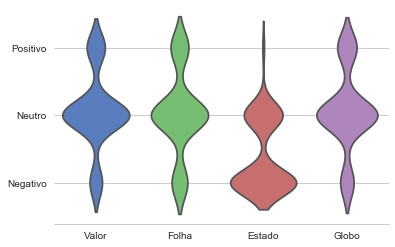

In [25]:
plt.show(g_pol_sentic)

---

## Mudança de abordagem

Como tenho dito, apesar do algoritmo retornar valores com alguma plausibilidade, ao chegar nesse ponto comecei a duvidar um pouco da abordagem — talvez em alguma medida por _buyer’s remorse_ —, e decidi experimentar algum algoritmo baseado em aprendizado de máquina.

### Um aparte sobre a tarefa de se classificar notícias
Como nesse caso para se “ensinar” algo é preciso de uma base de exemplo, classificada manualmente, me aventurei na base de manchetes fornecidas com o propósito de dividi-las entre notícias positivas, neutras e negativas. Enfretei problemas de dois tipos:

#### Sobre a melhor maneira de se classificar manualmente 500 notícias
Não imaginei que evitaria vieses. Pelo contrário: quis classificar as notícias sob meu único ponto de vista, ou seja, o que eu considero positivo vai ser desavergonhadamente positivo, neutro é neutro, negativo é negativo.

O que não antevi foi com que frequência eu teria dúvidas, e como o cansaço com a tarefa, ou mesmo a repetição de determinados temas, ia afetando minha convicção sobre certos temas conforme eu avançava na base — e, afinal, com 500 notícias creio que tenha sido quase duas horas para tê-las todas classificadas.

Para dar um exemplo: é minha opinião que em muitas instâncias o papel do BNDES na economia tem sido inchado, então uma notícia como “BNDES encolhe e volta ao nível de 20 anos atrás”, em uma primeira lida foi positiva. Mais para frente, no entanto, ao me deparar com “Financiamentos do BNDES têm maior queda em 22 anos.”, começo a ficar preocupado: inchado ou não, o banco talvez seja um instrumento importante — quem saberá dizer?! —, e não sei se quero que ele suma! Nesse caso... talvez seja uma notícia negativa?

Ou seja: não é fácil julgar as notícias de sopetão, ainda mais sem lê-las por inteiro, ainda mais se é preciso fazer muitas de uma vez. Talvez a tarefa de avaliação devesse ter sido feita aos poucos, em momentos sorteados, julgando a mesma manchete diversas vezes para considerar um valor menos sujeito a paixões momentâneas — do jeito que foi, creio que minha base classificada reflita intensamente esse processo tortuoso, ou seja, não há uma consistência de opinião que a percorra de cabo a rabo, e isso tem consequências ruins quando se quer pensar em uma possível _precisão_ do algoritmo, como veremos abaixo.


#### Quão objetivo pode-se ser ao julgar notícias?
A questão acima sofre ainda, a meu ver, da dificuldade fundamental que permeia a proposta do exercício em si: quão _objetivamente_ seria possível a valência de uma manchete? Ao se supor que há uma polaridade objetiva, há o pressuposto de bem e mal universais, ou seja, que uma dada notícia avança ou atrasa a raça humana de maneira uniequívoca. 

Na prática isso não é tão simples: uma notícia pode conter derrotas e vitórias simultâneas de pontos de vista conflitantes, mas para os quais não há um desempate que não parta de um ponto de vista subjetivo. O algoritmo deve ser esquerdista? De direita? Centrista? Pró-meio-ambiente? Pró-ruralistas? Mesmo essas divisões que se faz (esquerda-direita, trabalhador-patrão, liberdade-tradição etc) refletem determinadas visões da realidade, e qualquer algoritmo trará esses reflexos.

Se a base fosse de, por exemplo, resenhas de restaurantes, talvez o problema fosse menos polêmico, dado que é um passo mais simples assumir o ponto de vista de quem come, para quem positivo ou negativo tem sentidos mais nítidos: comer lá foi bom, comer lá foi ruim.

Com as notícias o problema é mais complexo.

---

Aceitando esses dois grandes poréns, mas esquecendo-os por um pouco: uma vez classificada a base parti para tentar implementar um classificador baseado no algoritmo _Naive Bayes_. O fiz seguindo o tutorial de [Sentdex](https://pythonprogramming.net/naive-bayes-classifier-nltk-tutorial/).

In [26]:
def n2_create_headline_list(filename):
  f = open(filename,'r')
  text = f.readlines()

  headlines = []
  sources = []

  for line in text:
    # retrieves polarity, day, month, year and newspaper.
    # Everything else assumed to be the headline.
    values = line.split(',',5)
    polarity = values[0][1:-1]
    date = (values[3],values[2][1:-1],values[1])
    newspaper = values[4][1:-1]

    # -2 because there will be a newline character
    headline = clean_quotes(clean_html_chars(values[5][1:-2]))

    words = []

    for w in word_tokenize(headline):
      if w not in stop_words_pt:
        words.append(w.lower())
        all_words.append(w.lower())

    # a tuple with a list of words (sans stop-words) in each headline and its polarity
    headlines.append((words,polarity))
    sources.append(newspaper)

  f.close()
  return (headlines,sources)

---

Acima, a função para importação do CSV, semelhante a sua versão anterior mas agora considerando que no arquivo há também um campo de polaridade. 

Monto também uma lista com todas as palavras, útil mais para frente.

---

In [27]:
import random
import nltk

In [28]:
def find_features(doc, word_features):
  words = set(doc)
  features = {}
  
  # features will be a dictionary registering the presence (and absence) 
  # of words in “doc” in the word_features list (which will be a subset
  # of the more frequent words in the headline corpus)
  for w in word_features:
    features[w] = (w in words)
  return features

In [29]:
all_words = []

headlines = n2_create_headline_list('manchetes/classificada_manualmente.csv')

# random.shuffle(headlines)

# list with all words, ordered by frequency in descending order  
all_words = nltk.FreqDist(all_words)

frequent_words = list(all_words.keys())

featuresets = [
  (find_features(w_headline, frequent_words), polarity) 
  for (w_headline,polarity) in headlines[0]]

---

Os `featuresets` são listas nas quais, para cada manchete, indicamos quais palavras, dentre *todas* as palavras encontradas em `headlines`, estão presentes, e quais não estão, além da classificação dada àquela manchete [pos, neu, neg].

Para se ter uma ideia, veja a lista impressa abaixo. Trata-se da primeira posição do `featuresets`, ou seja, equivale a primeira manchete (também impressa, para comparação. Vê-se que todas as primeiras palavras, presentes na manchete, estão marcadas como `True`, e as seguintes estão todas marcadas como `False`. Note também que não adicionei as _stop words_ em `featuresets`.

In [30]:
print("%s\n\n%s" % (headlines[0][0],featuresets[0]))

(['bndes', 'encolhe', 'volta', 'nível', '20', 'anos', 'atrás'], 'neg')

({'bndes': True, 'encolhe': True, 'volta': True, 'nível': True, '20': True, 'anos': True, 'atrás': True, 'bc': False, 'cria': False, 'novo': False, 'instrumento': False, 'política': False, 'monetária': False, '.': False, 'câmbio': False, 'gera': False, 'bate-boca': False, 'ua': False, 'ue': False, 'indenização': False, 'transmissoras': False, 'energia': False, 'chega': False, 'tarifa': False, 'políticos': False, 'esperam': False, 'relator': False, 'separe': False, '”': False, 'joio': False, 'trigo': False, 'philips': False, 'quer': False, 'administrar': False, 'hospitais': False, 'públicos': False, 'brasil': False, 'com': False, 'vendas': False, 'queda': False, ',': False, 'cc': False, 'muda': False, 'lojas': False, 'troca': False, 'diretoria': False, 'fachin': False, 'poderá': False, 'ir': False, 'turma': False, 'julga': False, 'lava-jato': False, 'eike': False, 'multas': False, 'superam': False, 'fundo': False, '

---

Como a base não é gigantesca, não foi preciso limitar esses dicionários, mas fosse esse o caso poderia se considerar um sub-conjunto de palavras mais frequentes — imaginando que uma palavra que só apareça uma vez, por exemplo, pouco serve para prever polaridade em outras frases.

---

In [31]:
frequent_words[:30]

['bndes',
 'encolhe',
 'volta',
 'nível',
 '20',
 'anos',
 'atrás',
 'bc',
 'cria',
 'novo',
 'instrumento',
 'política',
 'monetária',
 '.',
 'câmbio',
 'gera',
 'bate-boca',
 'ua',
 'ue',
 'indenização',
 'transmissoras',
 'energia',
 'chega',
 'tarifa',
 'políticos',
 'esperam',
 'relator',
 'separe',
 '”',
 'joio']

O `featureset`, então, nos servirá para calcular a frequência com que cada palavra aparece associada a cada classe.

---

## Que aspecto tem o banco classificado manualmente?

Com os dados importados, é possível plotar como ficou a classificação do banco, dividada entre as três polaridades e os quatro veículos de notícia: 

In [32]:
def convert_pol(s):
  if s == 'pos': return 1.0
  if s == 'neg': return -1.0
  if s == 'neu': return 0.0

In [33]:
n2_pol_calua_valor = []
n2_pol_calua_folha = []
n2_pol_calua_estado = []
n2_pol_calua_globo = []

for i in range(0,len(headlines[0])):
  
  pol = convert_pol(headlines[0][i][1])
  
  source = headlines[1][i]
  if source == 'Valor':
    n2_pol_calua_valor.append(pol)
  elif source == 'Folha':
    n2_pol_calua_folha.append(pol)
  elif source == 'Estado':
    n2_pol_calua_estado.append(pol)
  elif source == 'Globo':
    n2_pol_calua_globo.append(pol)
    

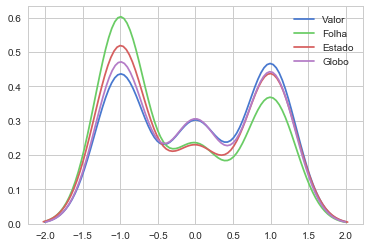

In [34]:
sns.distplot(n2_pol_calua_valor, hist=False, label='Valor')
sns.distplot(n2_pol_calua_folha, hist=False, label='Folha')
sns.distplot(n2_pol_calua_estado, hist=False, label='Estado')
sns.distplot(n2_pol_calua_globo, hist=False, label='Globo')

plt.show()

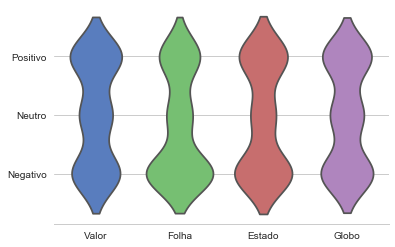

In [35]:
g_pol_calua = sns.violinplot(data=[
  n2_pol_calua_valor,
  n2_pol_calua_folha,
  n2_pol_calua_estado,
  n2_pol_calua_globo], inner=None)
sns.despine(left=True)

g_pol_calua.set_xticklabels(["Valor","Folha","Estado","Globo"])

g_pol_calua.set_yticks([1,0,-1])
g_pol_calua.set_yticklabels(["Positivo","Neutro","Negativo"])

g_pol_calua.figure

---

A título de comparação, o resultado da primeira abordagem, já citado anterioremente, é o seguinte:


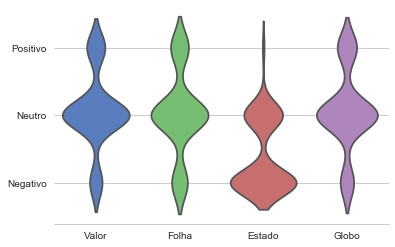

In [36]:
g_pol_sentic.figure

## Naive Bayes

Importada a base e definidas as [features](https://stackoverflow.com/questions/20827741/nltk-naivebayesclassifier-training-for-sentiment-analysis), partimos para o aprendizado.

Cabe ressaltar que escolhi o Naive Bayes pelo prosáico motivo de ser ele o primeiro exemplo nos tutoriais do [Sentdex](https://pythonprogramming.net/naive-bayes-classifier-nltk-tutorial/), mas não por isso essa é uma escolha necessariamente ruim. Apesar de algumas desvantagens, que citarei, para os nossos propósitos ele possui alguns bons pontos positivos:

- [Diz-se](https://youtu.be/sjUDlJfdnKM?t=37) que a análise de sentimento é um de seus usos mais comuns, e para a qual obtém-se bons resultados.;
- O algoritmo é de [relativa simplicidade conceitual](https://www.vooo.pro/insights/6-passos-faceis-para-aprender-o-algoritmo-naive-bayes-com-o-codigo-em-python/) e de implementação — é uma solução rápida e fácil, compatível com o escopo deste trabalho — e mesmo minha experiência no assunto;
- Apesar de que o pressuposto de independência de preditores não ser necessariamente válida para a aplicação em questão, na prática isso às vezes [não atrapalha muito](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/);
- Funciona para múltiplas classes (positivo, negativo **e** neutro).

Há desvantagens, claro — em especial, suas predições não tem alta precisão —, mas para nosso caso sinto que o maior limitador é a própria “má” qualidade da classificação manual, com as suas oscilações de humor citadas acima, e nesse sentido a diferença de algoritmo talvez importe relativamente pouco (faço uns testes mais para frente que indicam ser válida a hipótese).

---

In [37]:
cut_point = int(len(featuresets) * .85)

training_set = featuresets[:cut_point]
testing_set = featuresets[cut_point:]

classifier = nltk.NaiveBayesClassifier.train(training_set)

In [38]:
print("Naive Bayes accuracy:", nltk.classify.accuracy(classifier, testing_set))

Naive Bayes accuracy: 0.4266666666666667


---

Acima, a precisão atingida — bastante abaixo da faixa entre 60-75% [obtida por Sentdex](https://pythonprogramming.net/naive-bayes-classifier-nltk-tutorial/). A proporção entre `training_set` e `testing_set` foi definida experimentalmente: testei diversos `cut_points` diversas vezes e, na média, 85% foi o que melhor funcionou.

Abaixo, as 20 _features_ de maior relevância. Note que as proporções entre presença das palavras selecionadas nas duas classes indicadas são aqui menores do que as [obtidas por Sentdex](https://pythonprogramming.net/naive-bayes-classifier-nltk-tutorial/) a partir de uma base de resenhas de hotéis, ou seja, as palavras que tenho em minha base de manchetes são preditores piores que as que ele tem — e faz sentido, dado que no caso das resenhas trata-se de textos de opinião, cheios de adjetivos muito menos ambíguos. Uma resenha com a palavra _insulting_ dificilmente será positiva! Na lista abaixo, há poucos adjetivos, e os que há poderiam assumir tanto sentidos positivos quanto negativos (_menor_ e _nova_, no caso).

---

In [39]:
classifier.show_most_informative_features(20)

Most Informative Features
                       a = True              neu : neg    =      8.2 : 1.0
                  brasil = True              neu : neg    =      4.9 : 1.0
                   desde = True              neu : neg    =      4.4 : 1.0
                 joesley = True              neu : pos    =      3.6 : 1.0
                     vai = True              neu : neg    =      3.5 : 1.0
                       . = False             neg : pos    =      3.4 : 1.0
                   sobre = True              neu : neg    =      3.4 : 1.0
                   vence = True              neu : neg    =      3.2 : 1.0
                  dívida = True              neu : neg    =      3.2 : 1.0
                    nova = True              neu : neg    =      3.2 : 1.0
                   janot = True              neu : neg    =      3.2 : 1.0
                      20 = True              neu : neg    =      3.2 : 1.0
               políticos = True              neu : neg    =      3.2 : 1.0

In [40]:
n2_pol_machine_valor = []
n2_pol_machine_folha = []
n2_pol_machine_estado = []
n2_pol_machine_globo = []

for i in range(0, len(testing_set)):
  pol = classifier.classify(testing_set[i][0])
  pol = convert_pol(pol)
  source = headlines[1][i + cut_point]
  if source == 'Valor': n2_pol_machine_valor.append(pol)
  if source == 'Folha': n2_pol_machine_folha.append(pol)
  if source == 'Estado': n2_pol_machine_estado.append(pol)
  if source == 'Globo': n2_pol_machine_globo.append(pol)

---

Abaixo, a distribuição entre manchetes positivas, neutras e negativas nas quatro fontes de notícias de acordo com as predições do Naive Bayes.

Note que ele não é idêntico ao gráfico acima, que considera a “verdade” da minha classificação manual, mas um certo viês positivo no _Valor_ e outro negativo na _Folha_, que estão presentes no banco de treinamento, ressurgem no banco de testes.

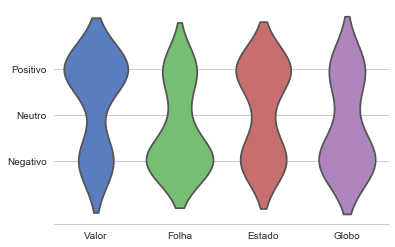

In [44]:
g_pol_machine = sns.violinplot(data=[
  n2_pol_machine_valor,
  n2_pol_machine_folha,
  n2_pol_machine_estado,
  n2_pol_machine_globo],inner=None)
sns.despine(left=True)

g_pol_machine.set_xticklabels(["Valor","Folha","Estado","Globo"])

g_pol_machine.set_yticks([1,0,-1])
g_pol_machine.set_yticklabels(["Positivo","Neutro","Negativo"])
plt.show()

---

## Outros algoritmos que não o Naive Bayes?

A título de curiosidade e seguindo os exemplos de [Sentdex](https://pythonprogramming.net/sklearn-scikit-learn-nltk-tutorial/?completed=/pickle-classifier-save-nltk-tutorial/), testei a mesma base de treinamento com diferentes algoritmos disponíveis na `scikit-learn`, e medi as diferentes precisões obtidas:

In [42]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC

In [43]:
print("Precisão do Naive Bayes:", (nltk.classify.accuracy(classifier, testing_set)))

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("Precisão do MNB_classifier:", (nltk.classify.accuracy(MNB_classifier, testing_set)))

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("Precisão do BernoulliNB_classifier:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set)))

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("Precisão do LogisticRegression_classifier:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set)))

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set)
print("Precisão do SVC_classifier:", (nltk.classify.accuracy(SVC_classifier, testing_set)))

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("Precisão do LinearSVC_classifier:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set)))

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("Precisão do NuSVC_classifier:", (nltk.classify.accuracy(NuSVC_classifier, testing_set)))

Precisão do Naive Bayes: 0.4266666666666667
Precisão do MNB_classifier: 0.4666666666666667
Precisão do BernoulliNB_classifier: 0.49333333333333335
Precisão do LogisticRegression_classifier: 0.44
Precisão do SVC_classifier: 0.4266666666666667
Precisão do LinearSVC_classifier: 0.41333333333333333
Precisão do NuSVC_classifier: 0.4266666666666667


As diferenças não são grandes, mas existem. Melhorando-se a base, um possível avanço na aplicação seria estudar essas alternativas.

---

## Conclusão 

A tomar de exemplo as soluções a que cheguei, ambas abordagens sofrem de grandes limitações, produzindo resultados a meu ver insatisfatórios para uma aplicação no mundo real. 

Ao mesmo tempo, mesmo um classificador humano poderia ser considerado “imperfeito” dependendo de qual parâmetro se estiver considerando, então há de se pensar que esta aplicação, imaginada como um “grande classificador de qualquer notícia”, talvez seja fadada ao fracasso. Alterando um pouco a proposta, imagino que a proposta teria mais sucesso se construída de acordo com um viés específico. Melhor dizendo, talvez fosse mais plausível obter sucesso com classificadores que atuassem em áreas mais estreitas (notícias de política, por exemplo), e que tivessem seus vieses explícitos (enfoque de _esquerda_ ou _direita_, por exemplo).

Ainda assim, mesmo um classificador mais geral e sem viés explícito, como propõe ser o analisador baseado em léxico (primeira proposta) consegue inferir *algum* compomente de sentimento nas manchetes fornecidas. Em algumas manchetes, os resultados parecem quase plausíveis, e pelos motivos certos:

```
Cehab corre até risco de despejo. >>> -1.65 
····· ····· ___ -0.87 __ -0.786 · 

Macri restringe imigração e causa polêmica. >>> -1.13 
····· ········· -0.32     _ ····· -0.817  ·

Contas do govertno têm maior rombo da história. >>> -0.28 
······ __ ········ ··· ····· -0.34 __ 0.063   · 

```

Assim, apesar de muitos falsos positivos e negativos, essa abordagem, aperfeiçoada, tem potencial. Como ela depende de léxicos construídos por terceiros, seria difícil conseguir incorporar nela as reflexões que fiz sobre vieses, mas isso não é necessariamente uma desvantagem: justamente, em situações em que se queira desconsiderar um ponto de vista político, este é um caminho que vale a pena perseguir.

Com a abordagem baseada em _Naive Bayes_, meu principal problema talvez tenha sido a classificação manual que fiz — e, no fundo, construir uma ferramenta que permita gerar essas _classificações_ é um desafio em si, e um no qual a questão da filiação ideológica dos avaliadores pode ser melhor tratada —, mas mesmo considerando que a base é de baixa qualidade o algoritmo ainda assim conseguiu capturar alguns dos padrões presentes na base, o que indica que esta é também uma abordagem promissora caso se queira avançar a proposta.